In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.api.models import Sequential
from keras.api.layers import Input, LSTM, Dense, Dropout

In [2]:
data  = pd.read_csv("issuer_data.csv")

In [3]:
data['Датум'] = pd.to_datetime(data['Датум'], format='%d.%m.%Y')
data = data.sort_values(by='Датум')

In [5]:
df = data.copy()

numeric_columns = [
     "Мак.", "Мин.", "Просечна цена", "%пром.", "Цена на последна трансакција",
     "Промет во БЕСТ во денари", "Вкупен промет во денари",
]

for col in numeric_columns:
    df[col] = (
        df[col]
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .replace("NaN", np.nan)
        .astype(float)
    )

In [6]:
list1 = list(df.select_dtypes(include=["number"]))
list1

['Цена на последна трансакција',
 'Мак.',
 'Мин.',
 'Просечна цена',
 '%пром.',
 'Количина',
 'Промет во БЕСТ во денари',
 'Вкупен промет во денари']

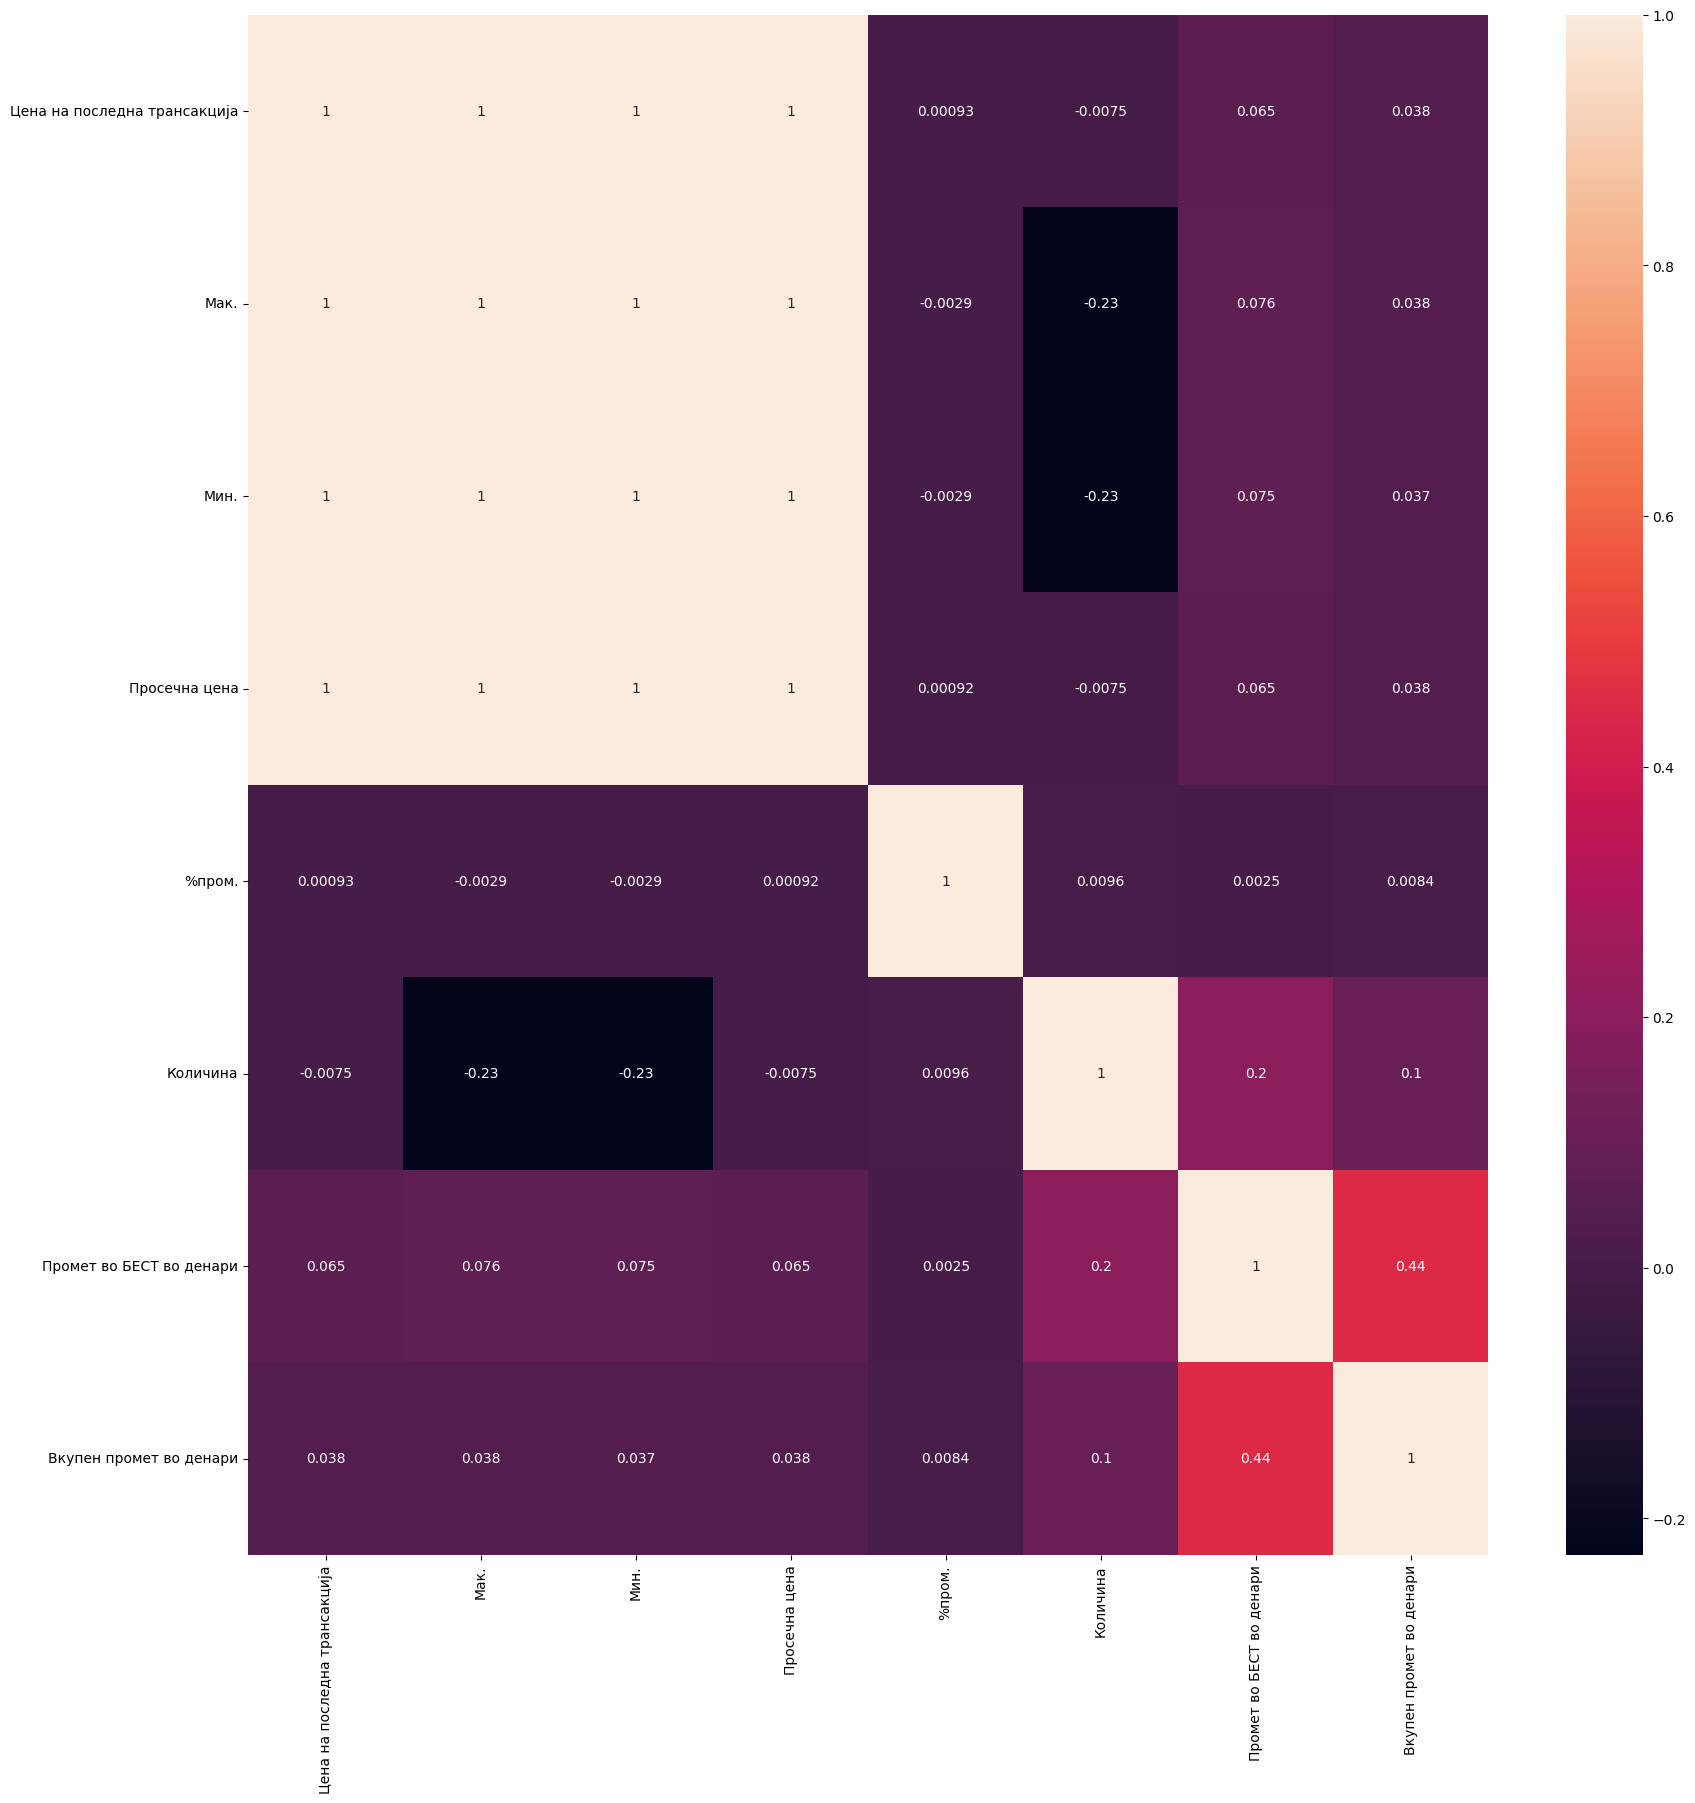

In [7]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[list1].corr(), annot=True)
plt.show()

In [8]:
# gi zemame slabo koreliranite tabeli
dataset = df[['Датум', 'Цена на последна трансакција', 'Издавач', '%пром.', 'Количина', 'Промет во БЕСТ во денари', 'Вкупен промет во денари']].dropna()

dataset['date'] = dataset['Датум']
dataset['price'] = dataset['Цена на последна трансакција']
dataset['issuer'] = dataset['Издавач']
dataset['change'] = dataset['%пром.']
dataset['quantity'] = dataset['Количина']
dataset['best'] = dataset['Промет во БЕСТ во денари']
dataset['sum'] = dataset['Вкупен промет во денари']

dataset = dataset[['date', 'price', 'issuer', 'change', 'quantity', 'best', 'sum']].dropna()
dataset.set_index('date', inplace=True)

In [9]:
def shift_values(data: pd.DataFrame, columns: list):
    data_copy = data.copy()

    for column in columns:
        data_copy[f'{column}_1'] = data_copy[column].shift(1)
        data_copy[f'{column}_2'] = data_copy[column].shift(2)
        data_copy[f'{column}_3'] = data_copy[column].shift(3)

    data_copy = data_copy[3:]

    return data_copy

In [12]:
# funkcija za koga sakame za 1 izdavach da napravime model
def convert(name, dataset: pd.DataFrame):
  curr_data = [i for i in dataset.itertuples() if i[2]==name]
  curr_data = pd.DataFrame(curr_data, columns=['date', 'price', 'issuer', 'change', 'quantity', 'best', 'sum'])
  curr_data.set_index('date', inplace=True)
  return curr_data

In [58]:
def transform(curr_data: pd.DataFrame):
  dft = curr_data.copy()

  date_range = pd.date_range(start=dft.index.min(), end=dft.index.max(), freq='D')

  df_filled = dft.reindex(date_range, fill_value=None)

  df_filled['price'] = df_filled['price'].interpolate(method='linear')
  df_filled['change'] = df_filled['change'].interpolate(method='linear')
  df_filled['quantity'] = df_filled['quantity'].interpolate(method='linear')
  df_filled['best'] = df_filled['best'].interpolate(method='linear')
  df_filled['sum'] = df_filled['sum'].interpolate(method='linear')

  df_filled['price'] = df_filled['price'].astype(float, errors='ignore')
  df_filled['change'] = df_filled['change'].astype(float, errors='ignore')
  df_filled['quantity'] = df_filled['quantity'].astype(float, errors='ignore')
  df_filled['best'] = df_filled['best'].astype(float, errors='ignore')
  df_filled['sum'] = df_filled['sum'].astype(float, errors='ignore')

  df_filled.reset_index(inplace=True)
  df_filled.rename(columns={'index': 'date'}, inplace=True)

  return df_filled

In [14]:
def prepare_data(dataset :pd.DataFrame):
  data = shift_values(dataset, columns=['price', 'change', 'quantity', 'best', 'sum'])
  X = data.drop(columns=['price', 'date', 'issuer'])
  Y = data['price']

  train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3, shuffle=False)

  scaler = MinMaxScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)

  return train_X, test_X, train_y, test_y

In [59]:
def make_model(train_X, test_X, train_y, test_y):

  train_X_laged = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
  test_X_laged = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

  model = Sequential([
    Input((train_X_laged.shape[1], train_X_laged.shape[2])),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
  ])

  model.compile(
      loss="mse",
      optimizer="adam",
      metrics=["r2_score", "mse", "mae"]
  )

  hist = model.fit(train_X_laged, train_y, validation_split=0.1, epochs=5, batch_size=32)
  pred_y = model.predict(test_X_laged)

  model.save("LSTM_model_for_DIANS.keras")

  # for loading and using the model use:
  # from tensorflow.keras.models import load_model
  # model = load_model('LSTM_model_for_DIANS.h5') or model = load_model('LSTM_model_for_DIANS.keras')

  return pred_y

In [31]:
# primer za predeviduvanje model so 1 izdavach
curr = convert('MODA', dataset)
curr2 = transform(curr)
train_X, test_X, train_y, test_y = prepare_data(curr2)
pred_y = make_model(train_X, test_X, train_y, test_y)

print("rezultati za model so eden izdavach MODA:")
print(r2_score(test_y, pred_y))
print(mean_absolute_error(test_y, pred_y))
print(mean_squared_error(test_y, pred_y))

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1656.9447 - mae: 34.6145 - mse: 1656.9447 - r2_score: -3.6619 - val_loss: 23.1689 - val_mae: 2.7228 - val_mse: 23.1689 - val_r2_score: 0.0000e+00
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.1248 - mae: 1.4433 - mse: 5.1248 - r2_score: 0.9822 - val_loss: 45.3472 - val_mae: 6.1254 - val_mse: 45.3472 - val_r2_score: 0.0000e+00
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.7138 - mae: 1.3074 - mse: 5.7138 - r2_score: 0.9827 - val_loss: 16.3409 - val_mae: 1.2095 - val_mse: 16.3409 - val_r2_score: 0.0000e+00
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 15.5263 - mae: 1.6200 - mse: 15.5263 - r2_score: 0.9555 - val_loss: 14.3895 - val_mae: 0.3754 - val_mse: 14.3895 - val_r2_score: 0.0000e+00
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.8048 - mae: 0.3362 - mse: 2.8048 - r2_score: 0.9911 - val_loss: 18.3521 - val_mae: 2.2141 - val_mse: 18.3521 - val_r2_score: 0.0000e+00
35/35 ━━━━

One model for all issuers:

In [52]:
# eden model za site izdavachi:

result = dataset.groupby("date").median(numeric_only=True)
result

,price,change,quantity,best,sum
date,,,,,
2014-11-13,730.0,0.0,0.0,0.0,0.0
2014-11-14,730.0,0.0,0.0,0.0,0.0
2014-11-17,730.0,0.0,0.0,0.0,0.0
2014-11-18,730.0,0.0,0.0,0.0,0.0
2014-11-19,730.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2024-11-06,1086.0,0.0,0.0,0.0,0.0
2024-11-07,1044.0,0.0,0.0,0.0,0.0
2024-11-08,1002.0,0.0,0.0,0.0,0.0


In [53]:
r1 = transform(result)

r1 = shift_values(r1, columns=['price', 'change', 'quantity', 'best', 'sum'])

In [54]:
X = r1.drop(columns=['price', 'date'])
Y = r1['price']

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3, shuffle=False)

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [57]:
pred_ymm = make_model(train_X, test_X, train_y, test_y)

print("results (with lag 3):")
print(r2_score(test_y, pred_ymm))
print(mean_absolute_error(test_y, pred_ymm))
print(mean_squared_error(test_y, pred_ymm))

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 698087.8750 - mae: 800.5669 - mse: 698087.8750 - r2_score: -25.7262 - val_loss: 10843.1865 - val_mae: 76.6959 - val_mse: 10843.1865 - val_r2_score: -6.7924
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 27954.9902 - mae: 133.6818 - mse: 27954.9902 - r2_score: -0.0702 - val_loss: 646.9041 - val_mae: 14.8027 - val_mse: 646.9041 - val_r2_score: 0.5351
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1607.5519 - mae: 28.4800 - mse: 1607.5519 - r2_score: 0.9363 - val_loss: 301.1933 - val_mae: 10.5533 - val_mse: 301.1933 - val_r2_score: 0.7835
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 481.2958 - mae: 14.0275 - mse: 481.2958 - r2_score: 0.9821 - val_loss: 158.2006 - val_mae: 5.3241 - val_mse: 158.2006 - val_r2_score: 0.8863
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 278.3195 - mae: 10.0054 - mse: 278.3195 - r2_score: 0.9892 - val_loss: 140.9937 - val_mae: 8.2107 - val_mse: 140.9937 - v